# Single Node Capacity Expansion Planning

In this example, we build a replica of [model.energy](https://model.energy). This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world. It includes capacity investments and dispatch optimisation. We deviate from model.energy by including an electricity demand profiles rather than a constant electricity demand.

In [1]:
import pandas as pd

import pypsa

## Techno-economic assumptions

We take techno-economic assumptions from the [technology-data](https://github.com/PyPSA/technology-data) repository which collects assumptions on costs and efficiencies:

In [2]:
YEAR = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{YEAR}.csv"
costs = pd.read_csv(url, index_col=[0, 1])
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs = costs.value.unstack().fillna({"discount rate": 0.07, "lifetime": 20, "FOM": 0})

Based on this, we calculate the marginal costs (€/MWh):

In [3]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

We also calculate the capital costs (i.e. annualised investment costs, €/MW/a or €/MWh/a for storage), using a small utility function to calculate the **annuity factor** to annualise investment costs based on is the discount rate $r$ and lifetime $n$.

In [4]:
def annuity(r: float, n: int) -> float:
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
a = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [6]:
costs["capital_cost"] = (a + costs["FOM"] / 100) * costs["investment"]

## Wind, solar and load time series

In [7]:
RESOLUTION = 3  # hours
url = "https://tubcloud.tu-berlin.de/s/9toBssWEdaLgHzq/download/time-series.csv"
ts = pd.read_csv(url, index_col=0, parse_dates=True)[::RESOLUTION]

In [8]:
ts.head(3)

,load_mw,pv_pu,wind_pu
timestamp,,,
2019-01-01 00:00:00,5719.26,0.0,0.1846
2019-01-01 03:00:00,5474.74,0.0,0.3146
2019-01-01 06:00:00,5413.39,0.0,0.4957


## Model initialisation

In [9]:
n = pypsa.Network()
n.add("Bus", "electricity", carrier="electricity")
n.set_snapshots(ts.index)

The weighting of the snapshots (e.g. how many hours they represent, see $w_t$ in problem formulation above) must be set in `n.snapshot_weightings`.

In [10]:
n.snapshot_weightings.loc[:, :] = RESOLUTION

Adding carriers (this is only necessary for convenience in plotting later):

In [11]:
carriers = [
    "wind",
    "solar",
    "hydrogen storage",
    "battery storage",
    "load shedding",
    "electrolysis",
    "turbine",
    "electricity",
    "hydrogen",
]
colors = [
    "dodgerblue",
    "gold",
    "black",
    "yellowgreen",
    "darkorange",
    "magenta",
    "red",
    "grey",
    "grey",
]
n.add("Carrier", carriers, color=colors)

Index(['wind', 'solar', 'hydrogen storage', 'battery storage', 'load shedding',
       'electrolysis', 'turbine', 'electricity', 'hydrogen'],
      dtype='object')

Adding load:

In [12]:
n.add(
    "Load",
    "demand",
    bus="electricity",
    p_set=ts.load_mw,
)

Index(['demand'], dtype='object')

Add a load shedding generator with high marginal cost of 2000 €/MWh:

In [13]:
n.add(
    "Generator",
    "load shedding",
    bus="electricity",
    carrier="load shedding",
    marginal_cost=2000,
    p_nom=ts.load_mw.max(),
)

Index(['load shedding'], dtype='object')

Adding the variable renewable generators works almost identically, but we also need to supply the capacity factors to the model via the attribute `p_max_pu`.

In [14]:
n.add(
    "Generator",
    "wind",
    bus="electricity",
    carrier="wind",
    p_max_pu=ts.wind_pu,
    capital_cost=costs.at["onwind", "capital_cost"],
    marginal_cost=costs.at["onwind", "marginal_cost"],
    p_nom_extendable=True,
)

Index(['wind'], dtype='object')

In [15]:
n.add(
    "Generator",
    "solar",
    bus="electricity",
    carrier="solar",
    p_max_pu=ts.pv_pu,
    capital_cost=costs.at["solar", "capital_cost"],
    marginal_cost=costs.at["solar", "marginal_cost"],
    p_nom_extendable=True,
)

Index(['solar'], dtype='object')

Adding a 3-hour battery:

In [16]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=3,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 3 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['battery storage'], dtype='object')

Adding a hydrogen storage system consisting of electrolyser, hydrogen turbine and underground storage, which can all be flexibly optimised:

In [17]:
n.add("Bus", "hydrogen", carrier="hydrogen")

Index(['hydrogen'], dtype='object')

In [18]:
n.add(
    "Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    carrier="electrolysis",
    p_nom_extendable=True,
    efficiency=costs.at["electrolysis", "efficiency"],
    capital_cost=costs.at["electrolysis", "capital_cost"],
)

Index(['electrolysis'], dtype='object')

In [19]:
n.add(
    "Link",
    "turbine",
    bus0="hydrogen",
    bus1="electricity",
    carrier="turbine",
    p_nom_extendable=True,
    efficiency=costs.at["OCGT", "efficiency"],
    capital_cost=costs.at["OCGT", "capital_cost"] / costs.at["OCGT", "efficiency"],
)

Index(['turbine'], dtype='object')

In [20]:
n.add(
    "Store",
    "hydrogen storage",
    bus="hydrogen",
    carrier="hydrogen storage",
    capital_cost=costs.at["hydrogen storage underground", "capital_cost"],
    e_nom_extendable=True,
    e_cyclic=True,
)

Index(['hydrogen storage'], dtype='object')

### Model run

In [21]:
n.optimize(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 262.53it/s]
INFO:linopy.io: Writing time: 0.28s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-cyqj98ih has 64246 rows; 29206 cols; 124144 nonzeros
Coefficient ranges:
  Matrix [2e-04, 3e+00]
  Cost   [1e+02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [5e+03, 1e+04]
Presolving model
33618 rows, 27784 cols, 92094 nonzeros  0s
Dependent equations search running on 8760 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
30698 rows, 24864 cols, 86254 nonzeros  0s
Presolve : Reductions: rows 30698(-33548); columns 24864(-4342); elements 86254(-37890)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(1.67832e+07) 0s
      16443     7.6901868845e+09 Pr: 3150(1.48491e+08); Du: 0(5.96436e-09) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29206 primals, 64246 duals
Objective: 8.09e+09
Solver model: available
Solver message: Optimal



      18623     8.0854953075e+09 Pr: 0(0); Du: 0(4.63398e-11) 7s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-cyqj98ih
Model status        : Optimal
Simplex   iterations: 18623
Objective value     :  8.0854953075e+09
P-D objective error :  9.4359024903e-16
HiGHS run time      :          6.58
Writing the solution to /tmp/linopy-solve-rf5rf_z6.sol


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

### Model evaluation

Total system cost by technology:

In [22]:
tsc = (
    pd.concat([n.statistics.capex(), n.statistics.opex()], axis=1).sum(axis=1).div(1e9)
)
tsc

component    carrier         
Generator    solar               1.338868
             wind                3.302899
Link         electrolysis        0.572558
             turbine             1.172863
StorageUnit  battery storage     0.944010
Store        hydrogen storage    0.563780
Generator    load shedding       0.190517
dtype: float64

In [23]:
tsc.sum()

np.float64(8.085495307499398)

The optimised capacities in GW (GWh for `Store` component):

In [24]:
n.statistics.optimal_capacity().div(1e3)

component    carrier         
Generator    load shedding         10.901160
             solar                 26.074984
             wind                  32.494732
Link         electrolysis           3.033972
             turbine               10.077269
StorageUnit  battery storage       14.826195
Store        hydrogen storage    3782.546276
dtype: float64

Energy balances on electricity side (in TWh):

In [25]:
n.statistics.energy_balance(bus_carrier="electricity").sort_values().div(1e6)

component    carrier          bus_carrier
Load         -                electricity   -66.266089
Link         electrolysis     electricity   -15.322172
StorageUnit  battery storage  electricity    -0.748846
Generator    load shedding    electricity     0.095258
Link         turbine          electricity     3.905576
Generator    solar            electricity    25.920328
             wind             electricity    52.415945
dtype: float64

Energy balances plot as time series (in MW):

(<Figure size 758.25x300 with 1 Axes>,
 <Axes: xlabel='snapshot', ylabel='Energy Balance []'>,
 <seaborn.axisgrid.FacetGrid at 0x72fff0b61160>)

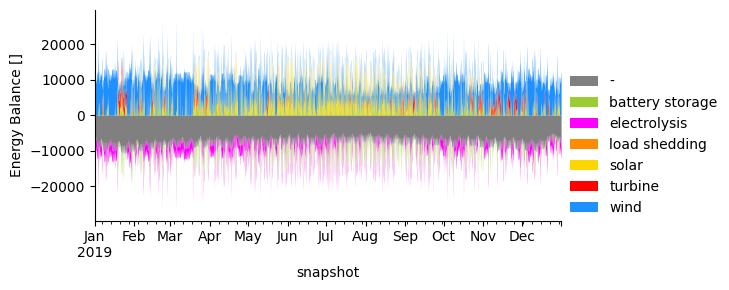

In [26]:
n.statistics.energy_balance.plot.area(linewidth=0, bus_carrier="electricity")

Price time series for electricity and hydrogen:

<Axes: xlabel='snapshot'>

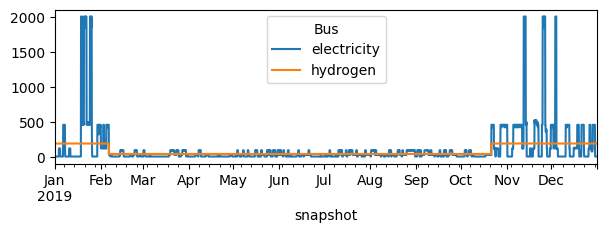

In [27]:
n.buses_t.marginal_price.plot(figsize=(7, 2))